### Binary classification of space weather events with Feature Selection

Feature selection for the binary classification task. The following methods were tested:
- Method 1: Random Forest Features importance
- Method 2: Hierarchical clustering on scattering features
- Method 3: PCA
- Method 4: Mutual Information
- Method 5: Recursive Features Elimination (with Cross-Validation)

In [57]:
import pandas as pd
import os
import numpy as np
import random
import torch
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from classification_utils import fill_NaN, compute_Scattering1D
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import fcluster
from sklearn.model_selection import train_test_split
from classification_utils import get_logistic_model, train_logistic_model, plot_confusion_matrix, plot_ROC_AUC
from sklearn.metrics import brier_score_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer, recall_score
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression  
from sklearn.metrics import accuracy_score
import shap
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.feature_selection import RFE, RFECV
import warnings
warnings.filterwarnings('ignore')

In [58]:
# paths
file_in_sample_path = 'labelled_data/selected_sample.txt' 
event_path = 'labelled_data/event/'
non_event_path = 'labelled_data/non-event/'

sample_n = len(os.listdir(event_path)) # number of non-events to pick randomly

# scattering best params
T = 20*60 + 1 # window len (seconds)
J = 10 # J ->  1201 ~ 2**J  ->  J ~ log_2(1201) ~ 10.91 --> seems better 10 or 9
Q = 5 # seems like the best value is between 5-6 
log_eps = 1e-6

Get data

In [59]:
# get sample non-event & all events

# if I already extracted a sample, read it, 
# else extract a sample and save it (for reproducibility)

if os.path.exists(file_in_sample_path):
    # if I already extracted a sample, read it
    all_seq_data_files = []
    with open(file_in_sample_path, "r") as file:
        for line in file:
            all_seq_data_files.append(line.strip())

else:
    # else, extract a sample
    # get all data files paths
    files_ev = [event_path + item for item in os.listdir(event_path)] 
    files_non_ev = [non_event_path + item for item in os.listdir(non_event_path)]

    random_non_ev = random.sample(files_non_ev, sample_n)
    all_seq_data_files = files_ev + random_non_ev

    # shuffle the files 
    random.shuffle(all_seq_data_files)

    # save sampled used to use always the same in the following trials
    with open(file_in_sample_path, 'w') as file:
        for string in all_seq_data_files:
            file.write(string + '\n')

In [60]:
# create sequences and labels 

# initialize 2D tensors (each row is a different sequence)
num_seq = len(all_seq_data_files)
sequences = torch.zeros(num_seq, T, dtype=torch.float32)
labels = torch.zeros(num_seq, dtype=torch.int64)

lab_dict = {'event':1, 'non-event':0}

filling_method = 'linear_interpolation' 

i = 0 # row of sequences tensor to update
for e in all_seq_data_files:
    # get sequence
    df = pd.read_csv(e)
    seq = df.sort_values(by=['Date_UTC' if 'Date_UTC' in df.columns else 'Unnamed: 0']).dbn_nez

    # get label
    y = [lab_dict['non-event'] if 'non-event' in e else lab_dict['event']][0]
    
    # deal with NaN
    seq_filled = fill_NaN(seq, filling_method)

    # convert from np array to pytorch tensor
    seq_filled = torch.from_numpy(seq_filled)

    # comput columns from which to start filling
    starting_col_index = (T - seq_filled.numel()) // 2
    
    # add data to sequences tensor
    sequences[i,starting_col_index:starting_col_index + seq_filled.numel()] = seq_filled

    # update label
    labels[i] = y

    # update counter (next row)
    i += 1

In [61]:
seq_df = pd.DataFrame(sequences)
seq_df['target'] = labels
events = seq_df[seq_df.target == 1].T.columns.to_list()

In [62]:
seq_df

,0,1,2,3,4,5,6,7,8,9,...,1192,1193,1194,1195,1196,1197,1198,1199,1200,target
0,-6.800000,-6.800000,-6.700000,-6.700000,-6.700000,-6.600000,-6.600000,-6.500000,-6.400000,-6.400000,...,5.100000,4.800000,4.500000,4.200000,3.900000,3.700000,3.400000,3.200000,3.000000,1
1,-10.200000,-10.100000,-9.900000,-10.000000,-10.100000,-9.900000,-9.700000,-9.800000,-9.800000,-9.800000,...,5.200000,5.100000,4.900000,4.600000,4.800000,4.700000,4.300000,4.400000,4.000000,1
2,4.100000,4.100000,4.100000,4.100000,4.100000,4.100000,4.100000,4.100000,4.100000,4.100000,...,5.100000,5.100000,5.100000,5.100000,5.000000,5.100000,5.000000,4.900000,4.800000,0
3,-51.299999,-51.299999,-51.299999,-51.299999,-51.299999,-51.299999,-51.200001,-51.200001,-51.200001,-51.099998,...,-16.799999,-16.799999,-16.799999,-16.799999,-16.799999,-16.799999,-16.799999,-16.799999,-16.799999,1
4,10.800000,10.800000,10.800000,10.800000,10.800000,10.800000,10.900000,10.900000,10.900000,10.900000,...,13.700000,13.700000,13.600000,13.600000,13.600000,13.600000,13.500000,13.500000,13.500000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381,12.600000,13.100000,13.000000,12.900000,13.200000,13.200000,13.200000,13.100000,12.800000,12.800000,...,22.400000,22.100000,22.100000,21.900000,22.000000,22.000000,22.100000,21.900000,21.700001,1
382,-33.700001,-33.700001,-33.700001,-33.700001,-33.700001,-33.700001,-33.700001,-33.700001,-33.700001,-33.700001,...,-5.300000,-5.300000,-5.500000,-5.600000,-5.800000,-6.000000,-6.100000,-6.200000,-6.300000,1
383,-35.599998,-35.500000,-35.500000,-35.599998,-35.599998,-35.500000,-35.500000,-35.500000,-35.599998,-35.500000,...,-34.299999,-34.299999,-34.299999,-34.299999,-34.299999,-34.299999,-34.299999,-34.299999,-34.299999,1
384,4.100000,4.100000,4.100000,4.100000,4.100000,4.100000,4.100000,4.000000,4.000000,4.000000,...,42.099998,42.099998,42.200001,42.200001,42.200001,42.299999,42.299999,42.299999,42.400002,1


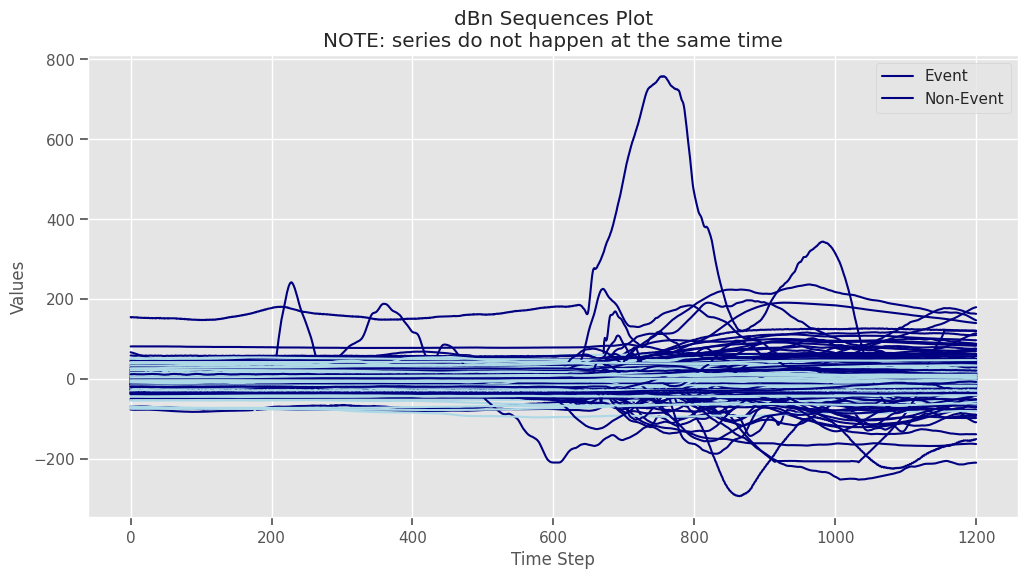

In [63]:
seq_df = pd.DataFrame(sequences).T

plt.figure(figsize=(12, 6))  
for feature in seq_df.columns:
    plt.plot(seq_df.index, seq_df[feature], color=['navy' if feature in events else 'lightblue'][0])

plt.xlabel('Time Step')
plt.ylabel('Values')
plt.title('dBn Sequences Plot\nNOTE: series do not happen at the same time')
plt.grid(True)
plt.legend(['Event', 'Non-Event'])  
plt.show()

Compute features

In [64]:
scat_feats = compute_Scattering1D(sequences, T, J, Q, log_eps)

In [65]:
np.shape(scat_feats) # (num_obs, num_feats)

torch.Size([386, 235])

In [66]:
np.isnan(scat_feats).any()

tensor(0, dtype=torch.uint8)

### Feature selection

#### Method 1: Random Forest Features importance

NOTE: in RF features importance, the fact that a subsequent feature have relative importance lower the the previous ones does not mean it does not have predictive power per sé. Rather, it means that the addition of such feature, after having already considered the previous ones, contribute to increase the cumulative explainability by a smaller factor.

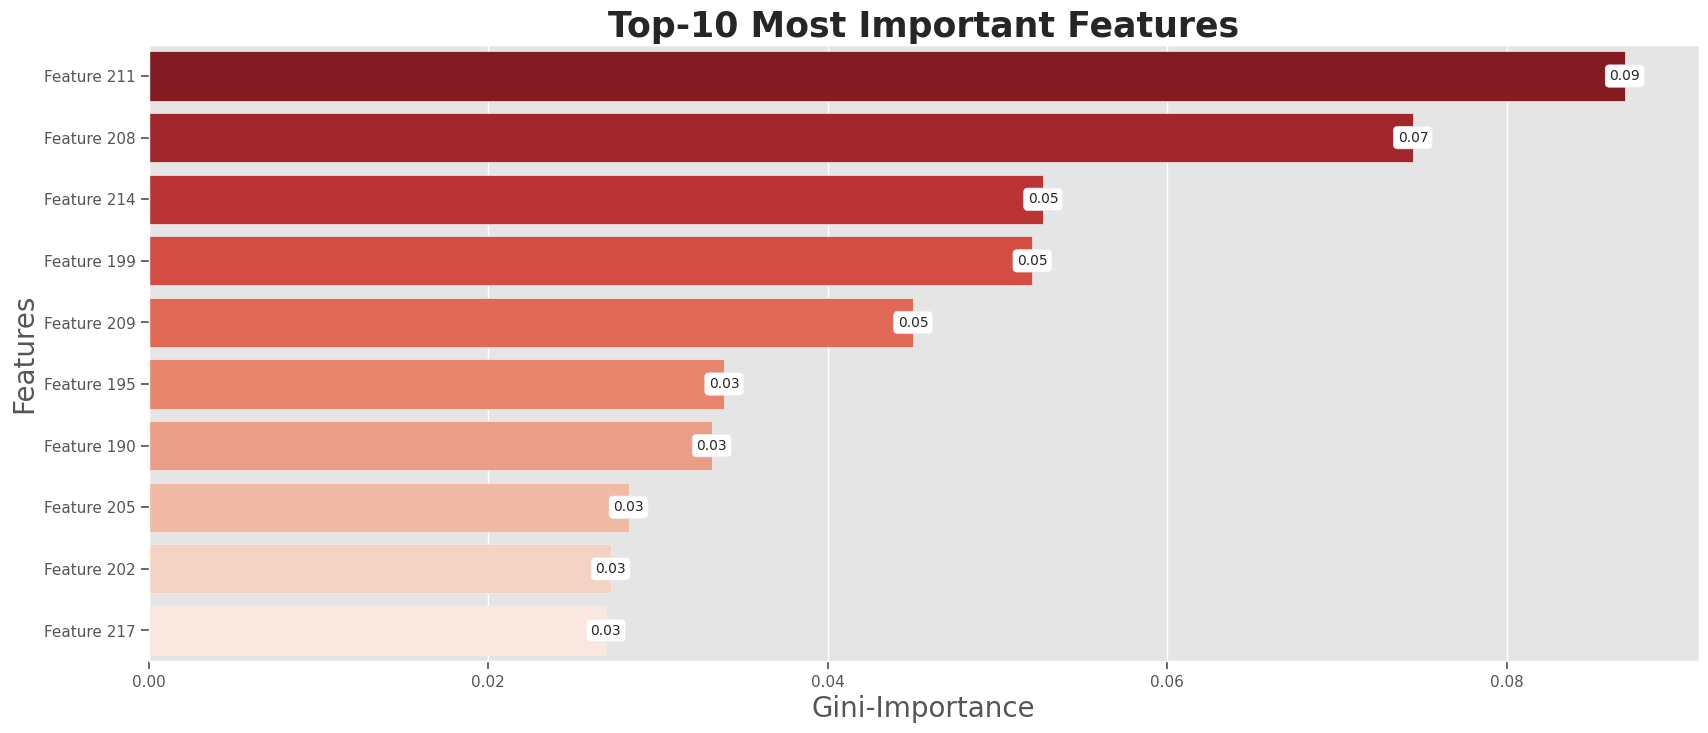

In [67]:
Sc_all_df = pd.DataFrame(scat_feats)

rf = RandomForestClassifier(max_depth=3, random_state=0)
rf.fit(Sc_all_df, labels)

# check which features are the most important in the random forest model
feats = {}
for feature, importance in zip(Sc_all_df.columns, rf.feature_importances_):
    feats[feature] = importance

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})


# Plot most important features
top_10 = importances[:10]
top_10['Features'] = top_10.Features.astype('str')
top_10['Features'] = ['Feature '+f for f in top_10.Features]

plt.figure(figsize=(20,8))
sns.barplot(x=top_10['Gini-Importance'], y=top_10['Features'], data=top_10,  palette='Reds_r')
plt.xlabel('Gini-Importance', fontsize=20)
plt.ylabel('Features', fontsize=20)
plt.title('Top-10 Most Important Features', fontsize=25, weight = 'bold')

i=1
for p in top_10['Gini-Importance']:
    x = p
    y = i-1
    lab = round(p, 2)
    plt.annotate(lab, (x,y), 
                bbox=dict(boxstyle='round', fc='w'), 
                va='center', ha='center')
    i+=1

plt.show()

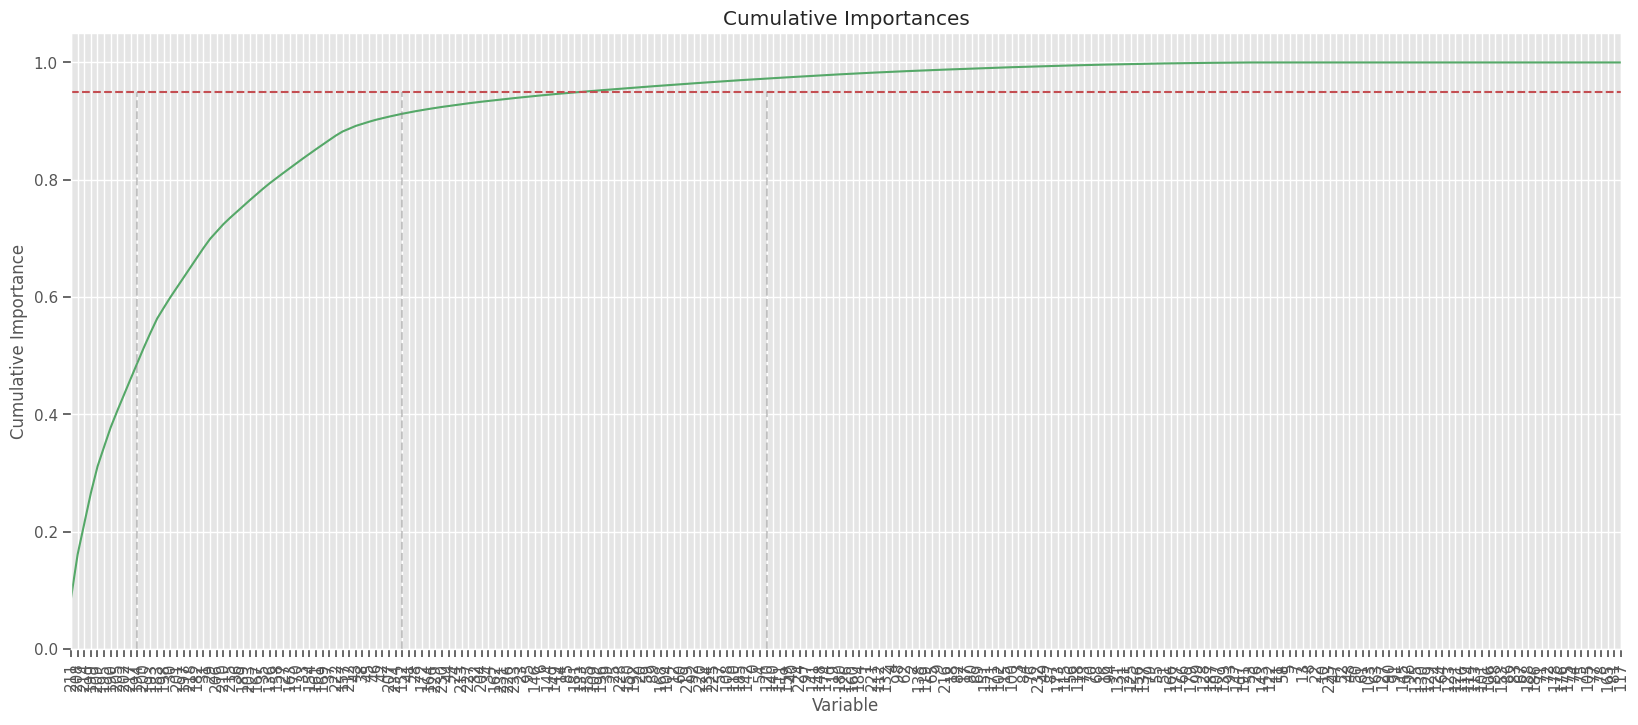

In [68]:
# cumulative importance
cumulative_importances = np.cumsum(importances['Gini-Importance'])

plt.figure(figsize=(20,8))

plt.plot(Sc_all_df.columns, cumulative_importances, 'g-')

# draw line at 95% of importance:
plt.hlines(y = 0.95, xmin=0, xmax=len(importances['Features']), color='r', linestyles='dashed')

# top 10 feats
plt.vlines(x=10, ymin=0, ymax=.95, color='gray', linestyles='dashed', alpha=0.4)

plt.vlines(x=50, ymin=0, ymax=.95, color='gray', linestyles='dashed', alpha=0.4)
plt.vlines(x=105, ymin=0, ymax=.95, color='gray', linestyles='dashed', alpha=0.4)

plt.xticks(Sc_all_df.columns, importances['Features'], rotation = 'vertical')
plt.xlabel('Variable')
plt.ylabel('Cumulative Importance')
plt.title('Cumulative Importances')

plt.xlim(xmin=0, xmax=len(importances['Features']) - 1)
plt.ylim(ymin=0)

plt.show()

Parallel coordinates plot

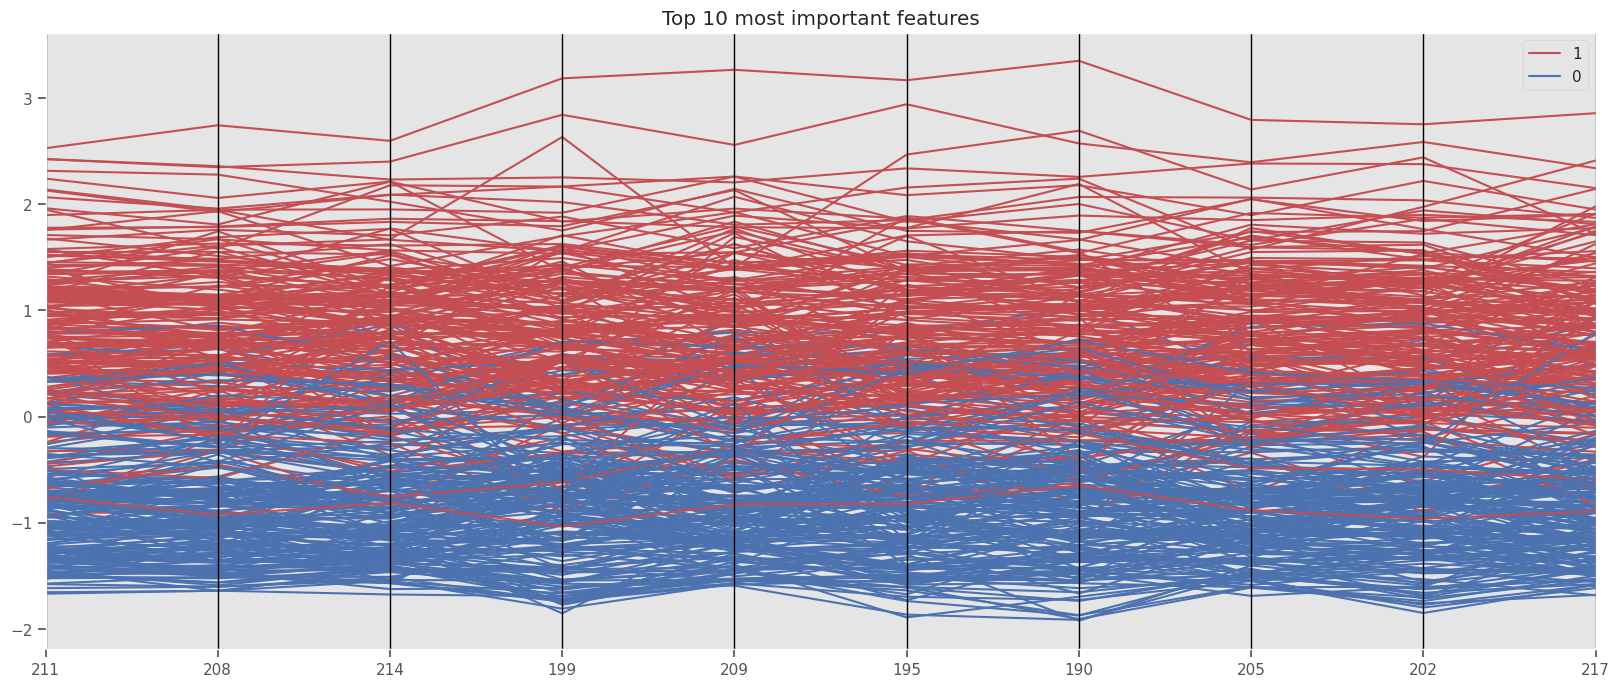

In [69]:
# parallel coordinates plot
# each data point (time step) is represented by a line in the plot and
# the position of the line along each axis corresponds to the value of that feature at that time step 

data_plt = pd.DataFrame(scat_feats)

select_feats = importances[:10].Features.to_list()

# normalize
data_plt = (data_plt[select_feats] - data_plt[select_feats].mean()) / data_plt[select_feats].std()

# add target to df
data_plt['target'] = labels

# parallel coordinates plot
plt.figure(figsize=(20,8))
plt.title('Top 10 most important features')
pd.plotting.parallel_coordinates(data_plt, class_column='target', cols=select_feats, color=['r','b'])
plt.show()

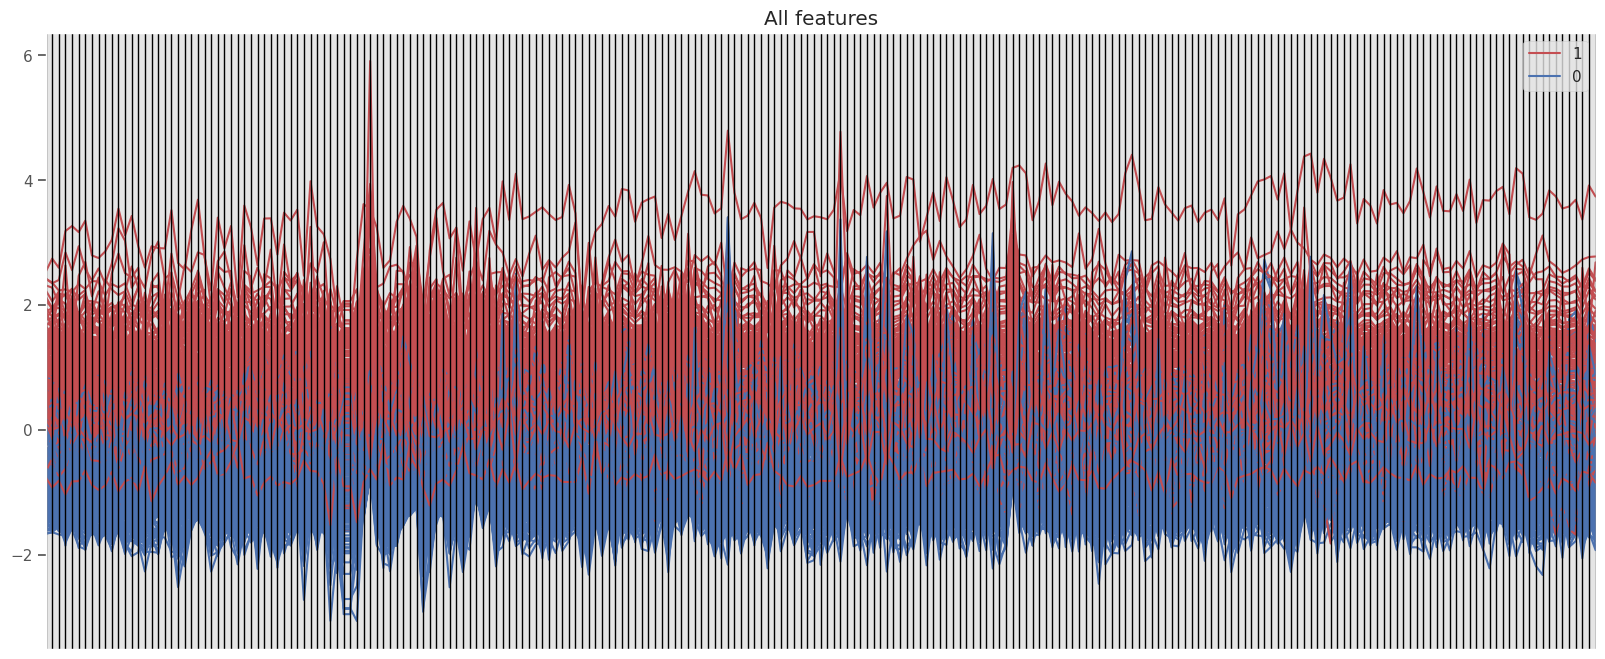

In [70]:
data_plt = pd.DataFrame(scat_feats)

select_feats = importances[:].Features.to_list()

# normalize
data_plt = (data_plt[select_feats] - data_plt[select_feats].mean()) / data_plt[select_feats].std()

# add target to df
data_plt['target'] = labels

# parallel coordinates plot
plt.figure(figsize=(20,8))
plt.title('All features')
pd.plotting.parallel_coordinates(data_plt, class_column='target', cols=select_feats, color=['r','b'])
plt.xticks([])
plt.show()

Pairwise Feature Plots

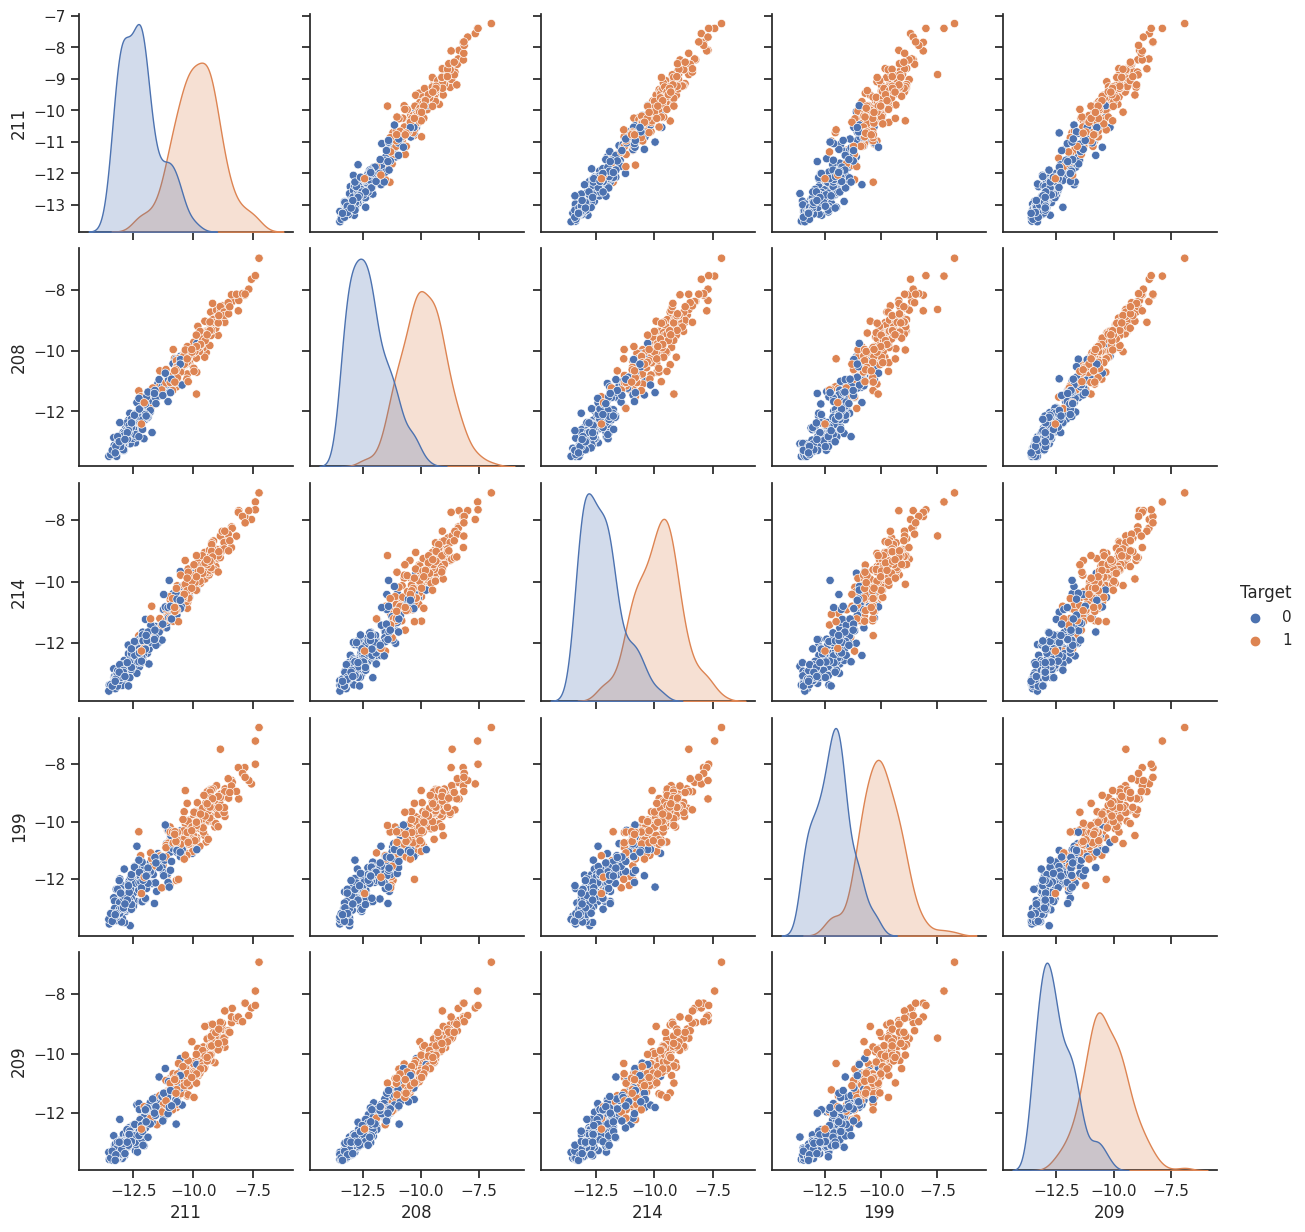

In [71]:
feature_importances = rf.feature_importances_

# select most important features
num_feats_to_select = 5
top_feats_index = np.argsort(feature_importances)[::-1][:num_feats_to_select]
# top_feats_names = [Sc_all_df[i] for i in top_feats_index]
top_feats_names = top_feats_index # columns names are num from 0

# df with feats and target
data_to_plot = Sc_all_df.loc[:, top_feats_index]
data_to_plot['Target'] = labels

# pairplot
sns.set(style='ticks')
sns.pairplot(data_to_plot, hue='Target', diag_kind='kde')
plt.show()


Correlations

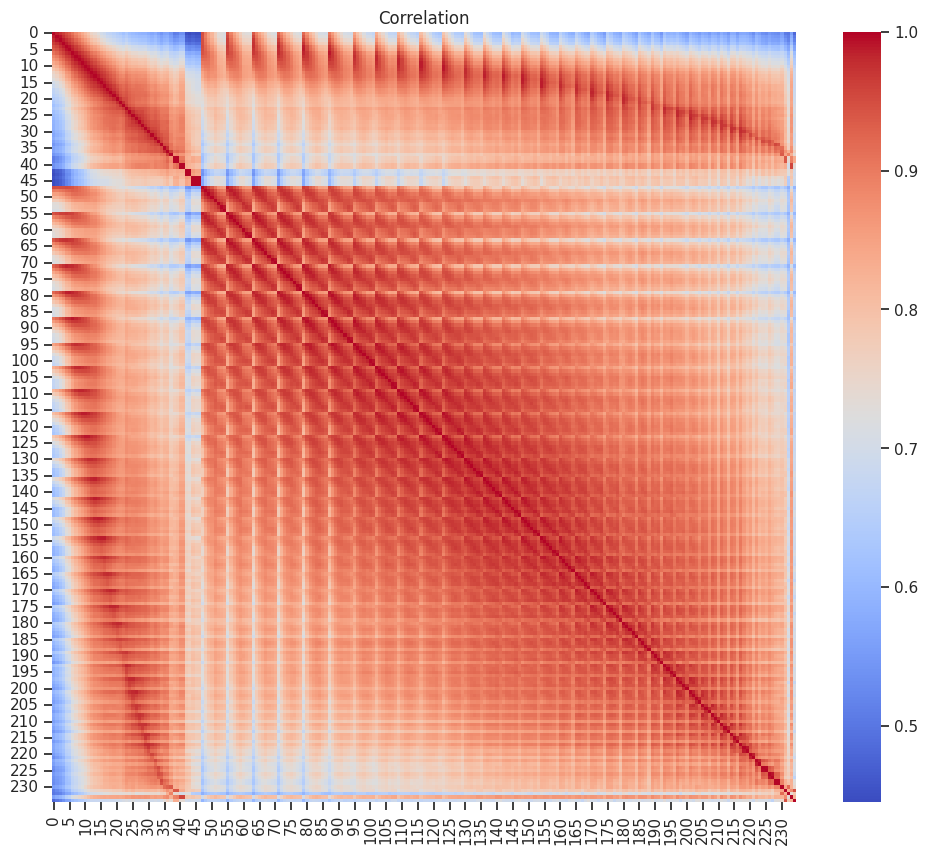

In [72]:
# correlation heatmap --> too many features --> reduce dimensionality
corr_matrix = Sc_all_df.corr()

plt.figure(figsize=(12, 10))  
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt='.2f')  
plt.title('Correlation')
plt.show()

________

#### Method 2: Hierarchical clustering on scattering features

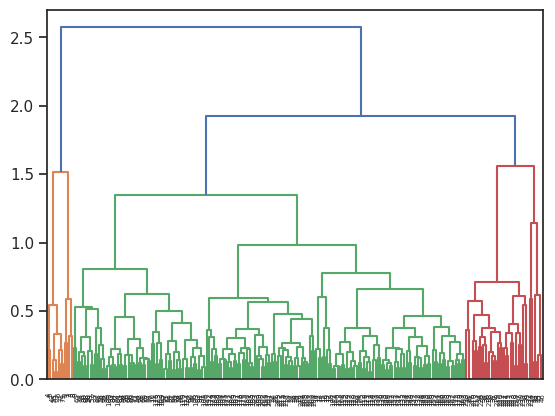

In [73]:
# test hierarchical clustering to group similar features, 
# and then visualize the correlation heatmap for these clusters.

# compute the linkage matrix
linkage_matrix = hierarchy.linkage(Sc_all_df.corr(), method='average')

# hierarchical clustering
dendrogram = hierarchy.dendrogram(linkage_matrix, labels=Sc_all_df.columns, orientation='top')

In [74]:
dendrogram

{'icoord': [[5.0, 5.0, 15.0, 15.0],
  [35.0, 35.0, 45.0, 45.0],
  [25.0, 25.0, 40.0, 40.0],
  [65.0, 65.0, 75.0, 75.0],
  [55.0, 55.0, 70.0, 70.0],
  [32.5, 32.5, 62.5, 62.5],
  [10.0, 10.0, 47.5, 47.5],
  [85.0, 85.0, 95.0, 95.0],
  [105.0, 105.0, 115.0, 115.0],
  [90.0, 90.0, 110.0, 110.0],
  [28.75, 28.75, 100.0, 100.0],
  [125.0, 125.0, 135.0, 135.0],
  [145.0, 145.0, 155.0, 155.0],
  [175.0, 175.0, 185.0, 185.0],
  [165.0, 165.0, 180.0, 180.0],
  [150.0, 150.0, 172.5, 172.5],
  [205.0, 205.0, 215.0, 215.0],
  [195.0, 195.0, 210.0, 210.0],
  [161.25, 161.25, 202.5, 202.5],
  [225.0, 225.0, 235.0, 235.0],
  [265.0, 265.0, 275.0, 275.0],
  [255.0, 255.0, 270.0, 270.0],
  [245.0, 245.0, 262.5, 262.5],
  [230.0, 230.0, 253.75, 253.75],
  [181.875, 181.875, 241.875, 241.875],
  [130.0, 130.0, 211.875, 211.875],
  [285.0, 285.0, 295.0, 295.0],
  [315.0, 315.0, 325.0, 325.0],
  [305.0, 305.0, 320.0, 320.0],
  [290.0, 290.0, 312.5, 312.5],
  [345.0, 345.0, 355.0, 355.0],
  [335.0, 335.0, 3

In [75]:
# select threshold to cut the dendogram and form clusters of features
threshold_height = 1.0 # 0.5  # cfr plot dendogram
clusters = fcluster(linkage_matrix, t=threshold_height, criterion='distance')

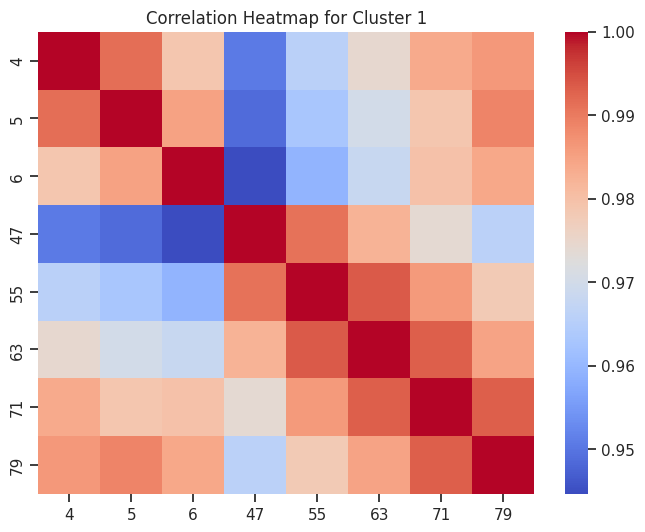

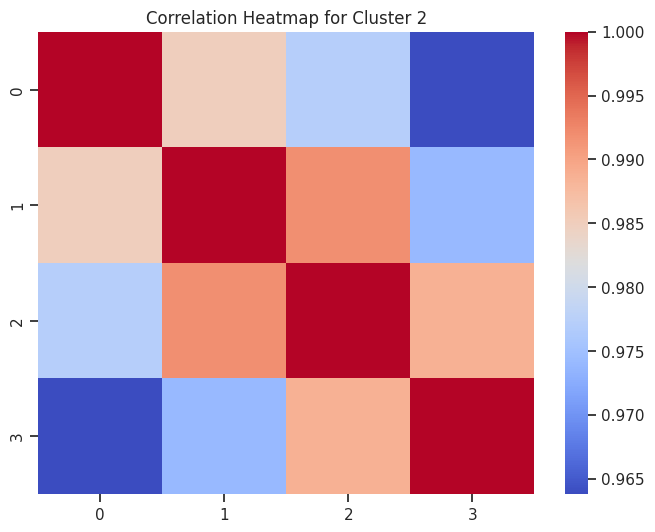

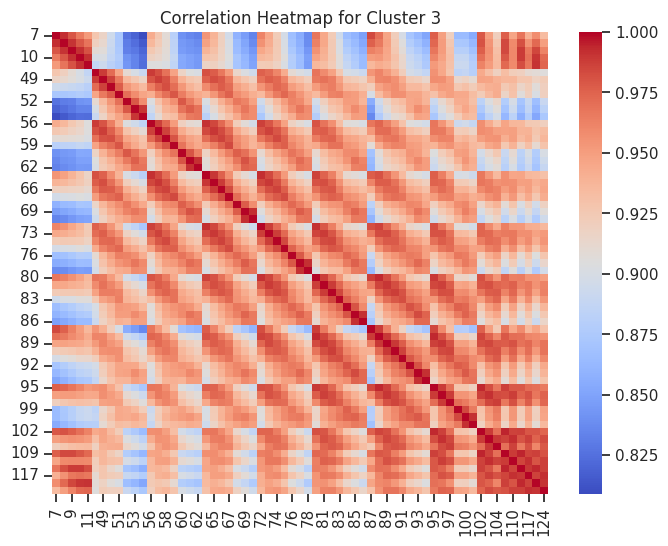

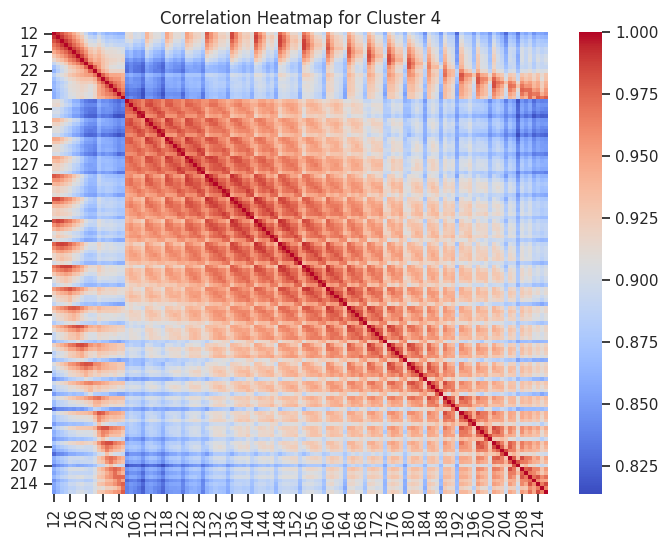

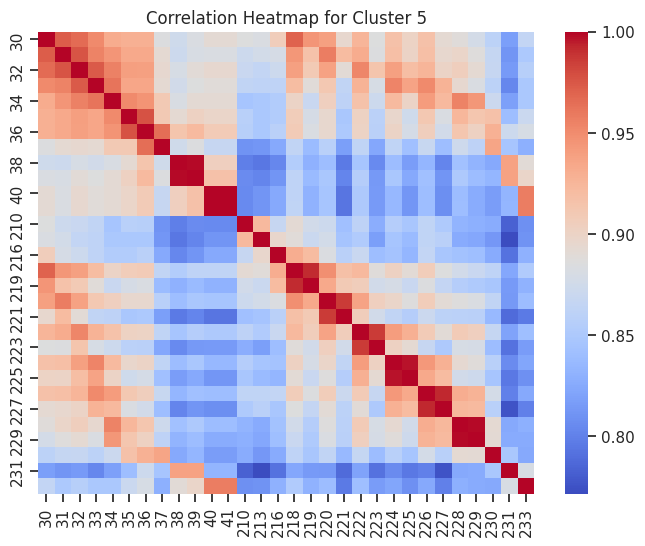

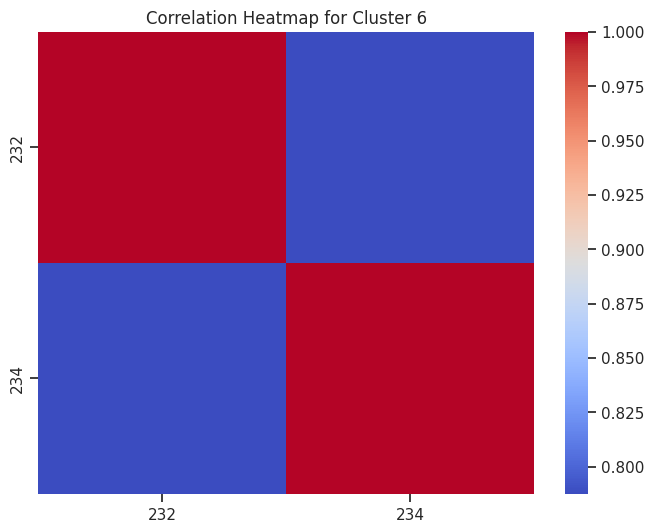

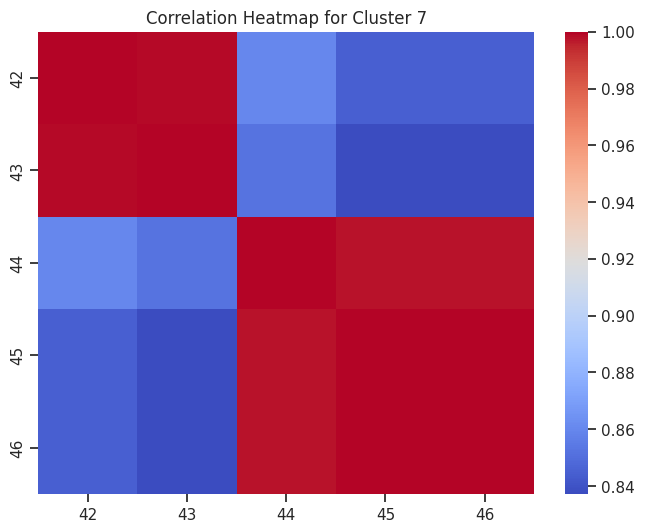

In [76]:
for cluster_num in set(clusters):
    # extract the features belonging to the current cluster
    cluster_features = [feature for feature, cluster in zip(Sc_all_df.columns, clusters) if cluster == cluster_num]
    
    # create a correlation matrix for the feats in the current cluster
    subset_corr = Sc_all_df[cluster_features].corr()
    
    # correlation heatmap for the current cluster
    plt.figure(figsize=(8, 6)) 
    sns.heatmap(subset_corr, annot=False, cmap='coolwarm', fmt='.2f')
    plt.title(f'Correlation Heatmap for Cluster {cluster_num}')
    plt.show()

Aggregate features: features within the same cluster have high similarity, thus clustering can be used to reduce the dimensionality by aggregating features in the same group into a single measure, such as the centroid.

In [77]:
np.unique(clusters)

array([1, 2, 3, 4, 5, 6, 7], dtype=int32)

In [78]:
set(clusters)

{1, 2, 3, 4, 5, 6, 7}

In [79]:
# compute clusters centroid
cluster_means = []

for clusters_num in set(clusters):
    cluster_features = [feature for feature, cluster in zip(Sc_all_df.columns, clusters) if cluster == cluster_num]
    cluster_data = Sc_all_df[cluster_features]
    cluster_means.append(np.mean(cluster_data, axis=1))

In [80]:
centroids_df = pd.DataFrame(cluster_means).T
centroids_df = centroids_df.add_prefix('centroid_cluster_')
centroids_df

,centroid_cluster_0,centroid_cluster_1,centroid_cluster_2,centroid_cluster_3,centroid_cluster_4,centroid_cluster_5,centroid_cluster_6
0,-5.053523,-5.053523,-5.053523,-5.053523,-5.053523,-5.053523,-5.053523
1,-5.257721,-5.257721,-5.257721,-5.257721,-5.257721,-5.257721,-5.257721
2,-7.025800,-7.025800,-7.025800,-7.025800,-7.025800,-7.025800,-7.025800
3,-4.339878,-4.339878,-4.339878,-4.339878,-4.339878,-4.339878,-4.339878
4,-6.823802,-6.823802,-6.823802,-6.823802,-6.823802,-6.823802,-6.823802
...,...,...,...,...,...,...,...
381,-5.313539,-5.313539,-5.313539,-5.313539,-5.313539,-5.313539,-5.313539
382,-4.393211,-4.393211,-4.393211,-4.393211,-4.393211,-4.393211,-4.393211
383,-7.365404,-7.365404,-7.365404,-7.365404,-7.365404,-7.365404,-7.365404
384,-3.905329,-3.905329,-3.905329,-3.905329,-3.905329,-3.905329,-3.905329


In [81]:
len(labels)

386

In [82]:
# try simple classification using clusters centroids as features

centroids_tensor = torch.tensor(centroids_df.values, dtype=torch.float32)

# split train and test set
X_train, X_test, y_train, y_test = train_test_split(centroids_tensor, labels, test_size=0.3, shuffle=True, random_state=42)
    
# standardize data using training mean and variance
mu_train = X_train.mean(dim=0)
std_train = X_train.std(dim=0)

Sx_train = (X_train - mu_train) / std_train
Sx_test = (X_test - mu_train) / std_train

# define logistic regression model
num_input = Sx_train.shape[-1]
num_classes = y_train.unique().numel()
model, opt, criterion = get_logistic_model(num_input, num_classes)

# train model 
num_epochs, n_samples, batch_size = 10, Sx_train.shape[0], 32
train_logistic_model(Sx_train, y_train, model, opt, 
                         criterion, num_epochs, n_samples, batch_size,
                         verbose=True)

Epoch 0, average loss = 0.603, accuracy = 0.633
Epoch 1, average loss = 0.575, accuracy = 0.696
Epoch 2, average loss = 0.551, accuracy = 0.737
Epoch 3, average loss = 0.530, accuracy = 0.741
Epoch 4, average loss = 0.511, accuracy = 0.774
Epoch 5, average loss = 0.496, accuracy = 0.793
Epoch 6, average loss = 0.482, accuracy = 0.800
Epoch 7, average loss = 0.470, accuracy = 0.796
Epoch 8, average loss = 0.460, accuracy = 0.807
Epoch 9, average loss = 0.452, accuracy = 0.819


In [83]:
# accuracy
resp = model.forward(Sx_test)
avg_loss = criterion(resp, y_test)

y_hat = resp.argmax(dim=1)
acc = (y_test == y_hat).float().mean()

print('Model accuracy: ', acc.item())

# confusion matrix
preds_test = y_hat.numpy()
true_test = y_test.numpy()
confusion = confusion_matrix(true_test, preds_test)

# probabilities of class assignment
model.eval() 
with torch.no_grad():
    logits = model(Sx_test)
    probs = torch.softmax(logits, dim=1)
    
brier_score = brier_score_loss(y_test, probs[:, 1])

# ROC
fpr, tpr, thresholds = roc_curve(true_test, probs[:, 1].numpy())
# AUC
auc = roc_auc_score(y_test.numpy(), probs[:, 1].numpy())

Model accuracy:  0.8620689511299133


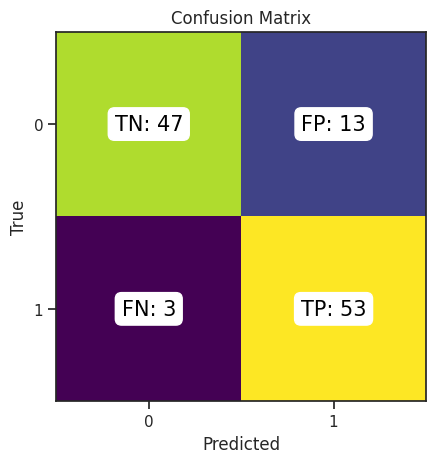

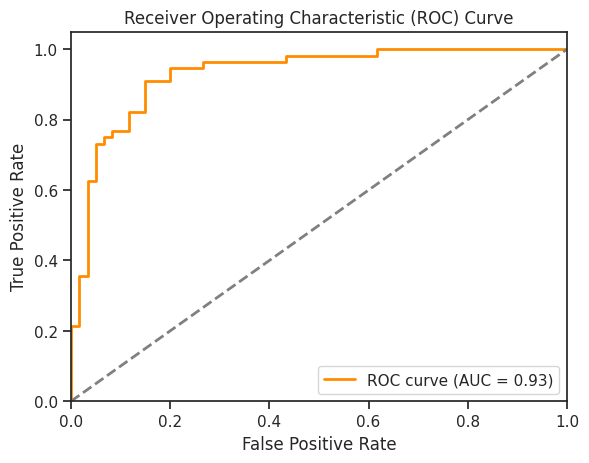

In [84]:
plot_confusion_matrix(confusion)
plot_ROC_AUC(fpr, tpr, auc)

___________

#### Method 3: PCA

Explained variation per principal component: [0.86580235 0.04630787 0.01386193]


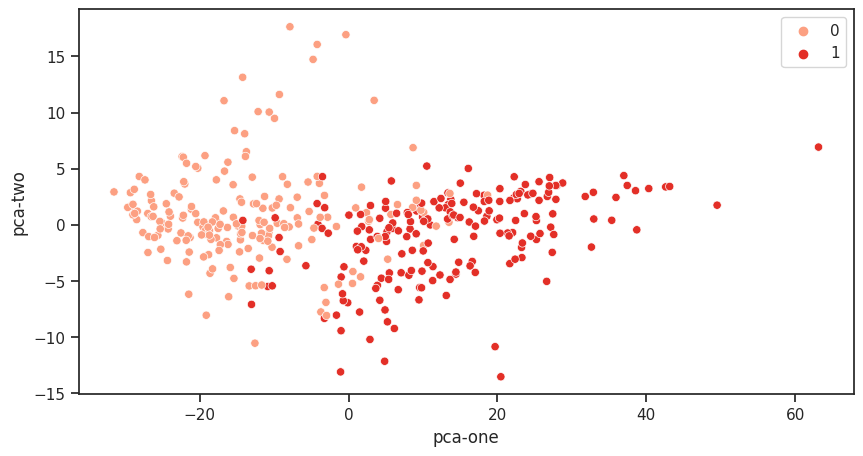

In [85]:
# PCA 
num_pc = 3
pca = PCA(n_components=num_pc) 
pca_result = pca.fit_transform(Sc_all_df) 

# put PC in feats_df 
feats['pca-one'] = pca_result[:,0]
feats['pca-two'] = pca_result[:,1] 
# feats['pca-three'] = pca_result[:,2]

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

# plot scatterplot of first PC on x axis and second PC on y axis
plt.figure(figsize=(10,5))
sns.scatterplot( 
    x='pca-one', 
    y='pca-two',
    hue=labels, 
    palette=sns.color_palette('Reds', 2),
    data=feats,
    legend='full')
plt.show()

In [86]:
np.cumsum(pca.explained_variance_ratio_)

array([0.86580235, 0.9121102 , 0.92597216], dtype=float32)

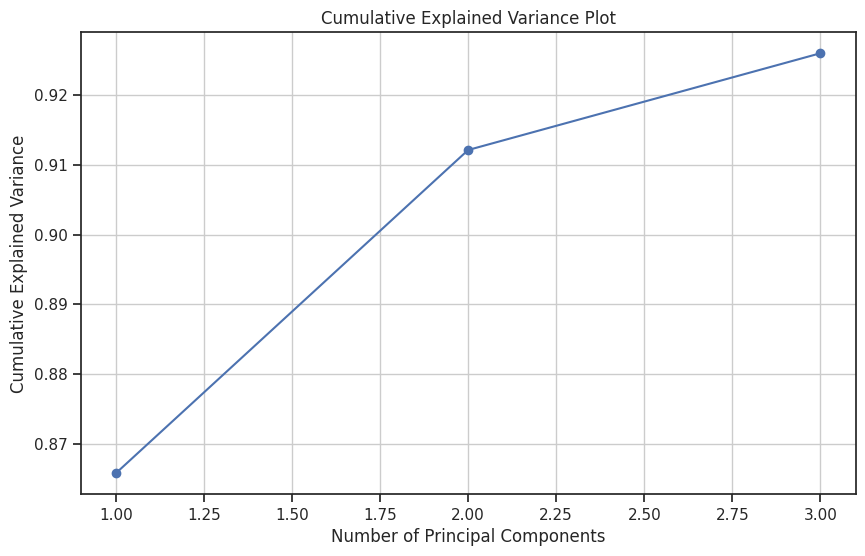

In [87]:
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='-')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance Plot')
plt.grid()
plt.show()

PC1 is capturing a significant amount of the variance in the data (around 85.9%), which suggests that there is a linear pattern well-captured by this component. Thus, PC1 is effectively reducing the dimensionality of the data while retaining a large portion of the information.  
Adding PC2 only allows to explain around 4.3% more of the variance.

In [88]:
# compute loadings  of first PC
# loadings represent the strength and direction of the relationship 
# between each feature and the principal component
# most loadings are high and positive --> very strong and positive relation between feats and PC1
PC1 = pca_result[:,0]
loadings = np.dot(Sc_all_df.T, PC1)
loadings

array([ 3353.8953,  3487.7395,  3639.1064,  3829.0312,  4129.7656,
        4340.1895,  4674.9243,  4942.1064,  5273.991 ,  5618.8706,
        5959.2915,  6266.844 ,  6596.678 ,  6910.9253,  7155.3594,
        7322.864 ,  7427.0757,  7562.093 ,  7711.8286,  7834.995 ,
        7792.9805,  7781.397 ,  8134.4795,  8662.843 ,  8828.509 ,
        9138.559 ,  9489.558 ,  9806.689 , 10010.843 , 10243.601 ,
       10683.448 , 10857.015 , 10673.57  , 10770.258 , 10305.851 ,
       11315.169 , 10951.277 , 10182.356 , 10872.341 , 10803.353 ,
       10248.864 , 10243.488 ,  8477.51  ,  8416.605 ,  9335.067 ,
        9314.397 ,  9314.397 ,  4287.4014,  5051.064 ,  5694.28  ,
        6287.7705,  6831.583 ,  7123.952 ,  7186.7817,  6811.4805,
        4349.885 ,  5171.6816,  5816.008 ,  6470.0903,  6992.994 ,
        7293.929 ,  7356.912 ,  6918.6304,  4453.5527,  5331.6353,
        6027.8193,  6681.7544,  7111.8403,  7482.7485,  7445.0874,
        7033.4414,  4613.9263,  5501.821 ,  6242.479 ,  6856.4

Test a model with PC as inputs

In [89]:
X_train, X_test, y_train, y_test = train_test_split(pca_result, labels, test_size=0.2, random_state=42)

logmodel = LogisticRegression()
logmodel.fit(X_train, y_train)
y_pred = logmodel.predict(X_test)

In [90]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.9358974358974359

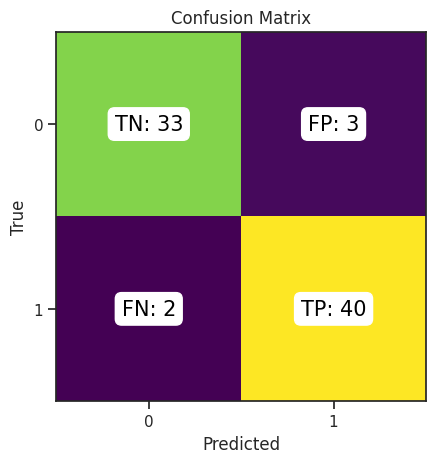

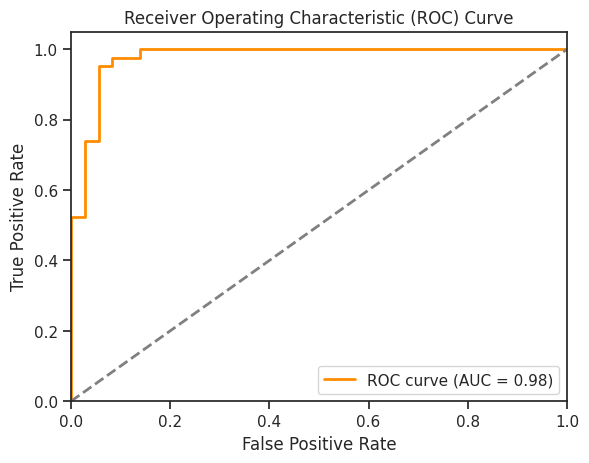

Brier Score:0.055499095047424514


In [91]:
# confusion matrix
confusion = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(confusion)

# ROC & AUC
probs = logmodel.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, probs[:, 1])
auc = roc_auc_score(y_test, probs[:, 1])
plot_ROC_AUC(fpr, tpr, auc)

# Brier Score
brier_score = brier_score_loss(y_test, probs[:, 1])
print(f'Brier Score:{brier_score}')

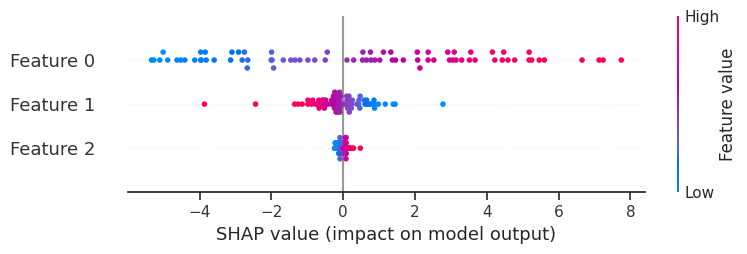

In [92]:
# use SHAP for features importance and contribution of PC
# explainer obj to apply to trained model
explainer = shap.Explainer(logmodel, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

____

#### Method 4: Mutual Information

In [93]:
# mutual info (dependency between vars --> the higher, the better; 0 = indep)
mi = mutual_info_classif(Sc_all_df, labels)

In [94]:
featureMI = pd.DataFrame({'mutual_information': mi, 'feature': Sc_all_df.columns})
print(featureMI.nlargest(10,'mutual_information'))

     mutual_information  feature
211            0.464939      211
208            0.461683      208
194            0.459629      194
202            0.455693      202
198            0.449750      198
206            0.449681      206
214            0.448509      214
205            0.447329      205
199            0.437327      199
217            0.436929      217


In [95]:
# select the top k features based on mutual information
k = 10
selector = SelectKBest(score_func=mutual_info_classif, k=k)
X_new = selector.fit_transform(Sc_all_df, labels)

# Get the selected feature indices
selected_features_indx = selector.get_support(indices=True)

print("Selected feature indices:", selected_features_indx)


Selected feature indices: [194 198 199 202 205 206 208 211 214 217]


In [96]:
topk_mi = torch.tensor(Sc_all_df[selected_features_indx].values, dtype=torch.float32)
topk_mi

tensor([[ -8.9968,  -8.7151,  -9.3298,  ...,  -9.3414,  -9.2967,  -9.4642],
        [ -9.6085,  -9.9051, -10.5595,  ...,  -9.8507,  -9.8845, -10.2514],
        [-11.3869, -11.3762, -11.8098,  ..., -12.1464, -12.0891, -12.1226],
        ...,
        [-11.6059, -11.9822, -12.4980,  ..., -12.1662, -12.2608, -12.4120],
        [-10.0305,  -9.9631, -10.4426,  ..., -10.7740, -10.8425, -10.8770],
        [-11.8043, -11.8008, -11.8914,  ..., -11.9693, -11.7510, -11.9295]])

In [97]:
# logistic regression with only topk feats for mutual information

# split train and test set
X_train, X_test, y_train, y_test = train_test_split(topk_mi, labels, test_size=0.3, shuffle=True, random_state=42)
    
# standardize data using training mean and variance
mu_train = X_train.mean(dim=0)
std_train = X_train.std(dim=0)

Sx_train = (X_train - mu_train) / std_train
Sx_test = (X_test - mu_train) / std_train

# define logistic regression model
num_input = Sx_train.shape[-1]
num_classes = y_train.unique().numel()
model, opt, criterion = get_logistic_model(num_input, num_classes)

# train model 
num_epochs, n_samples, batch_size = 10, Sx_train.shape[0], 32
train_logistic_model(Sx_train, y_train, model, opt, 
                         criterion, num_epochs, n_samples, batch_size,
                         verbose=True)

###################### EVALUATION ######################

# accuracy
resp = model.forward(Sx_test)
avg_loss = criterion(resp, y_test)

y_hat = resp.argmax(dim=1)
acc = (y_test == y_hat).float().mean()

print('Model accuracy: ', acc.item())

# confusion matrix
preds_test = y_hat.numpy()
true_test = y_test.numpy()
confusion = confusion_matrix(true_test, preds_test)

# probabilities of class assignment
model.eval() 
with torch.no_grad():
    logits = model(Sx_test)
    probs = torch.softmax(logits, dim=1)
    
brier_score = brier_score_loss(y_test, probs[:, 1])

# ROC
fpr, tpr, thresholds = roc_curve(true_test, probs[:, 1].numpy())
# AUC
auc = roc_auc_score(y_test.numpy(), probs[:, 1].numpy())

Epoch 0, average loss = 0.503, accuracy = 0.867
Epoch 1, average loss = 0.467, accuracy = 0.874
Epoch 2, average loss = 0.437, accuracy = 0.867
Epoch 3, average loss = 0.412, accuracy = 0.870
Epoch 4, average loss = 0.390, accuracy = 0.870
Epoch 5, average loss = 0.373, accuracy = 0.870
Epoch 6, average loss = 0.358, accuracy = 0.870
Epoch 7, average loss = 0.345, accuracy = 0.870
Epoch 8, average loss = 0.335, accuracy = 0.874
Epoch 9, average loss = 0.326, accuracy = 0.874
Model accuracy:  0.9396551847457886


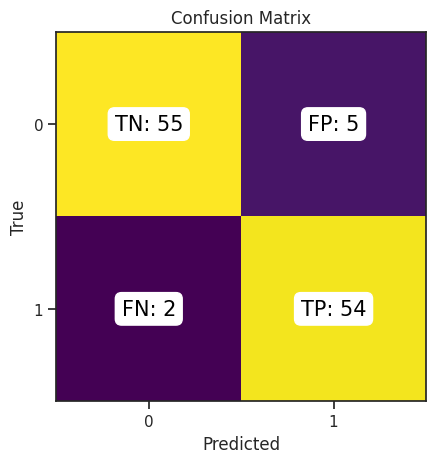

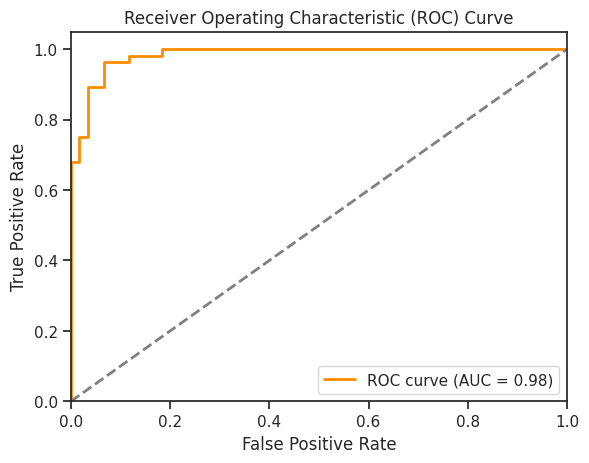

In [98]:
plot_confusion_matrix(confusion)
plot_ROC_AUC(fpr, tpr, auc)

In [99]:
# F1 Score = 2 * (Precision * Recall) / (Precision + Recall)
f1 = f1_score(true_test, preds_test)
print('F1 Score:', f1)

F1 Score: 0.9391304347826087


In [100]:
# Brier Score
brier_score = brier_score_loss(true_test, probs[:, 1])
print(f'Brier Score:{brier_score}')

Brier Score:0.06955843575447158


_______

#### Method 5: Recursive Features Elimination (with Cross-Validation)

[Docs](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html): iterative feature selection technique that starts with all features and gradually eliminates the least important ones until a desired number of features or a certain performance threshold is reached

In [101]:
# split data
X_train, X_test, y_train, y_test = train_test_split(scat_feats, labels, test_size=0.3, random_state=42)

# model to use to perform RFE
log_model = LogisticRegression()

# create RFE object & specify its parameters
num_features_to_select = 5  # num of features to retain at the end
step = 5 # num of features to remove at each iteration

## rfe = RFE(estimator=log_model, n_features_to_select=num_features_to_select, step=step)

# create RFE with CV
min_features_to_select = 3
cv = 10 # 10-folds CV
score = make_scorer(recall_score) # prioritize RECALL --> predicting the class 'event' correctly is more important [must predict the more possible “event” correctly]

rfe = RFECV(estimator=log_model, 
            min_features_to_select=min_features_to_select, 
            step=step,
            cv=cv,
            scoring=score) # RECALL

rfe.fit(X_train, y_train)

RFECV(cv=10, estimator=LogisticRegression(), min_features_to_select=3,
      scoring=make_scorer(recall_score), step=5)

In [102]:
selected_features = rfe.support_
feature_ranking = rfe.ranking_

In [103]:
# selected features
true_indices = np.where(selected_features)[0]
true_indices

array([  0,   1,   2,   3,   4,   5,   6,  11,  12,  13,  14,  18,  19,
        20,  21,  22,  23,  24,  25,  26,  27,  30,  33,  35,  36,  38,
        39,  42,  43,  47,  48,  49,  53,  55,  56,  60,  62,  66,  68,
        69,  70,  73,  74,  78,  81,  83,  85,  86,  89,  92,  93,  94,
        98, 103, 106, 108, 110, 113, 114, 115, 117, 118, 120, 121, 122,
       125, 127, 128, 129, 130, 131, 132, 133, 134, 136, 137, 138, 139,
       141, 142, 145, 146, 147, 149, 150, 151, 152, 157, 161, 167, 169,
       171, 172, 174, 177, 178, 179, 180, 181, 182, 183, 186, 187, 189,
       191, 194, 195, 197, 199, 201, 202, 203, 204, 205, 206, 207, 208,
       211, 212, 213, 214, 215, 216, 217, 219, 222, 223, 224, 225, 226,
       228, 229, 230, 232, 233])

In [104]:
len(true_indices)

135

In [105]:
# retain only selected features
X_train_rfe = X_train[:, selected_features]
X_test_rfe = X_test[:, selected_features]

# fit previously chosen model
log_model.fit(X_train_rfe, y_train)

LogisticRegression()

In [106]:
preds = log_model.predict(X_test_rfe)

In [107]:
accuracy_score(y_test, preds)

0.9310344827586207

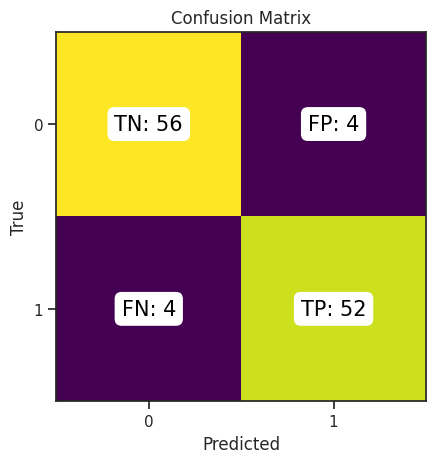

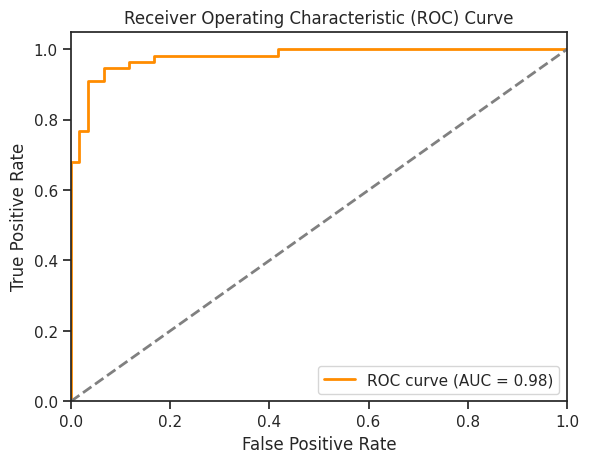

Brier Score:0.0543256380408243


In [108]:
# confusion matrix
confusion = confusion_matrix(y_test, preds)
plot_confusion_matrix(confusion)

# ROC & AUC
probs = log_model.predict_proba(X_test_rfe)
fpr, tpr, thresholds = roc_curve(y_test, probs[:, 1])
auc = roc_auc_score(y_test, probs[:, 1])
plot_ROC_AUC(fpr, tpr, auc)

# Brier Score
brier_score = brier_score_loss(y_test, probs[:, 1])
print(f'Brier Score:{brier_score}')